In [1009]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 
from chocolates import chocolate_masking_weighted, chocolate_mean_masking_weighted

def segmentation(img):
    # --- 1. Load and Resize Image ---
    img = cv2.resize(img, (1600,1067))

    # --- 2. Convert to HSV ---
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV_FULL)
    value = hsv[:, :, 2]

    # Gaussian blur to reduce noise
    value = cv2.GaussianBlur(value, (5, 5), 0) #(5,5)
    #plt.imshow(value, cmap='gray')

    # --- 4. Canny Edge Detection ---
    edges = cv2.Canny(value, 50, 100) #(50, 100)
    #plt.imshow(edges, cmap='gray')

    # --- 5. Dilate to Connect Broken Edges ---
    radius = 2 #2
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    dilated = cv2.dilate(edges, kernel, iterations=1)
    #plt.imshow(dilated, cmap='gray')

    # --- 6. Remove small objects ---

    # Label connected components
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(dilated, connectivity=8)

    # Set a minimum size threshold (in pixels)
    min_size = 2000  # adjust as needed

    # Create output image
    output = np.zeros(dilated.shape, dtype=np.uint8)

    for i in range(1, num_labels):  # skip label 0 (background)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            output[labels == i] = 255

    #plt.imshow(output, cmap='gray')

    contours, hierarchy = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # --- 7. Replace small contour filtering with ellipse fitting ---
    mask = np.zeros_like(dilated)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 30000:  # adjust the area threshold as needed
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
            
    #plt.imshow(mask, cmap='gray')

    # contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # for cnt in contours:
    #     area = cv2.contourArea(cnt)
    #     if area < 30000:  # adjust the area threshold as needed
    #         cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    #plt.imshow(mask, cmap='gray')

    # Close objects
    radius = 4
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)

    plt.imshow(mask, cmap='gray')

    # # Dilate to connect broken edges
    # radius = 2
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    # mask = cv2.dilate(mask, kernel, iterations=1)

    #plt.imshow(mask, cmap='gray')

    # Separate objects
    radius = 40
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*radius+1, 2*radius+1))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    #plt.imshow(mask, cmap='gray')

    # --- 8. Apply Mask to Original Image ---
    segmented_objects = cv2.bitwise_and(img, img, mask=mask)

    return segmented_objects

def plot_choc(img):
    plt.figure()
    plt.imshow(img)
    plt.title("Chocolate")
    plt.axis('off')
    plt.show()

def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    ax1.imshow(original)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    plt.show()

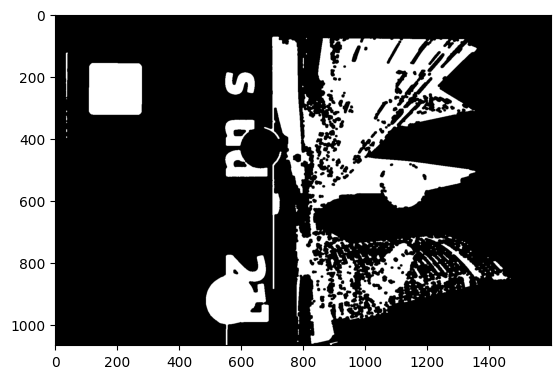

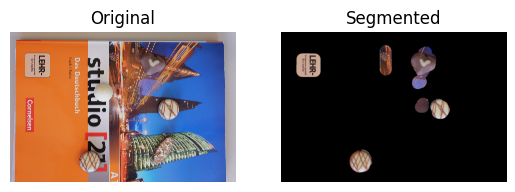

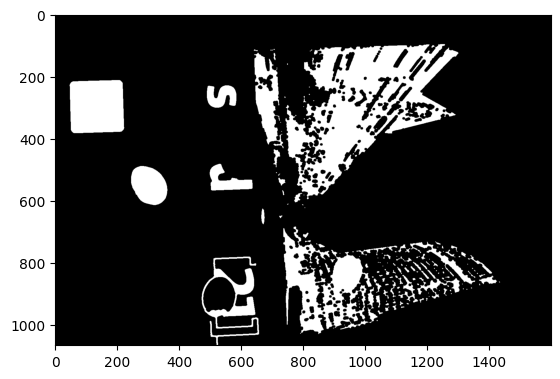

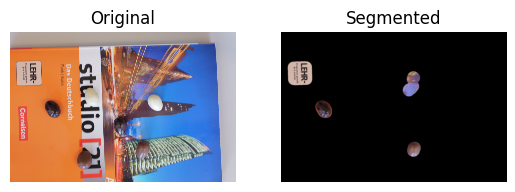

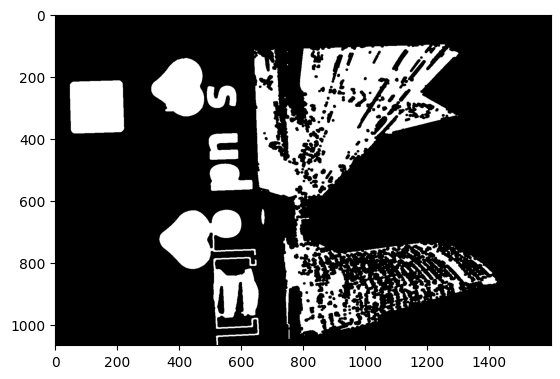

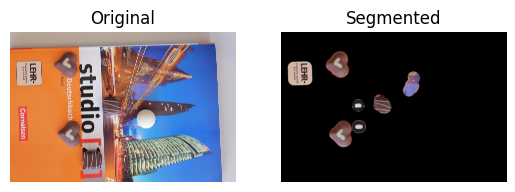

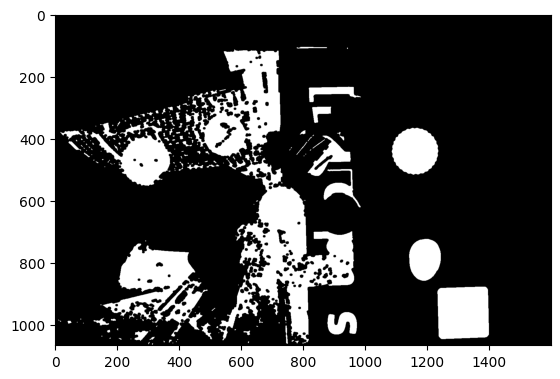

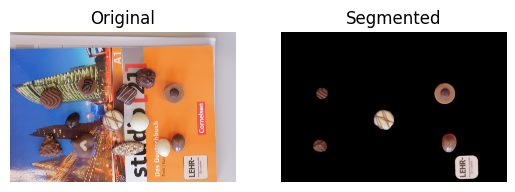

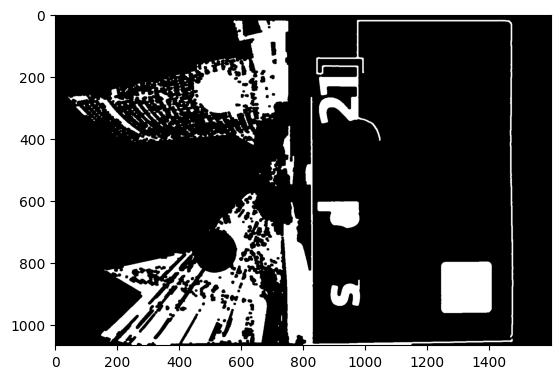

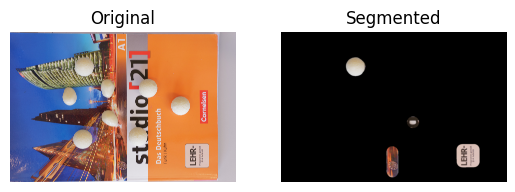

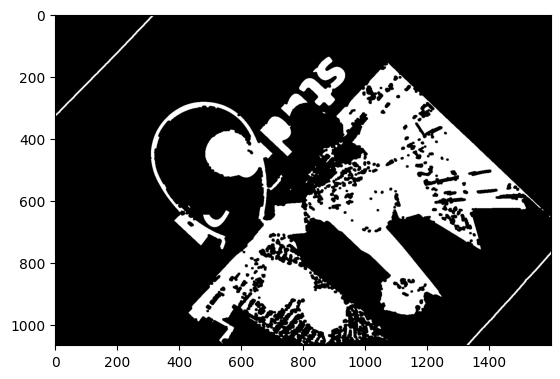

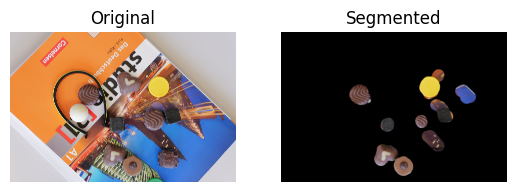

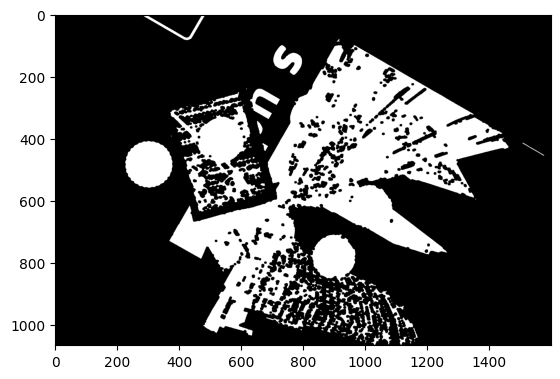

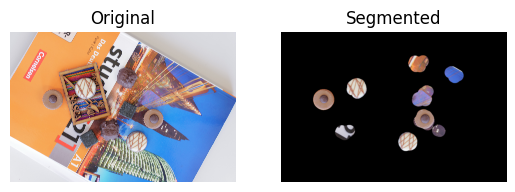

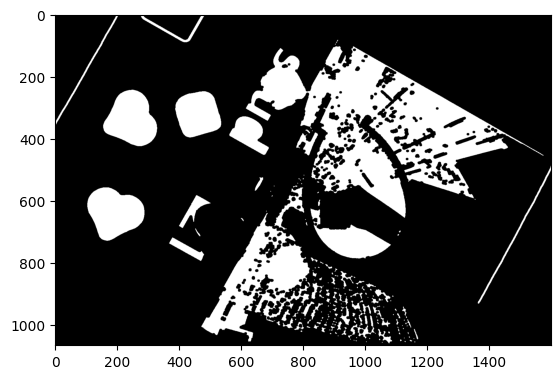

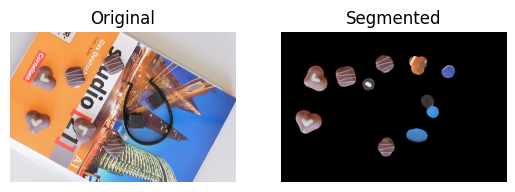

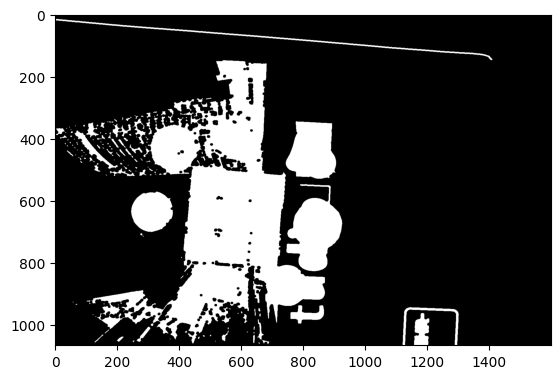

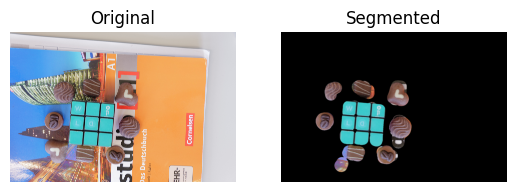

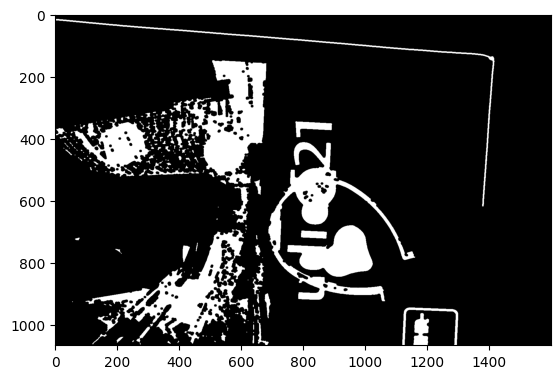

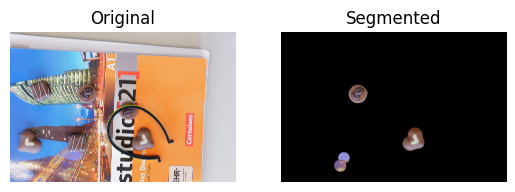

In [1013]:
path_ref = 'dataset_project_iapr2025/background_orange_book/'
jpg_files = [f for f in os.listdir(path_ref)]
#im_org = os.path.join(path_ref, jpg_files[5])
img = mpimg.imread(im_org)
res = segmentation(img)
#plot_choc(res)
#show_comparison(img, res, "Segmented")

for i in range(len(jpg_files)):
    im_org = os.path.join(path_ref, jpg_files[i])
    img = mpimg.imread(im_org)
    res = segmentation(img)
    #plot_choc(res)
    show_comparison(img, res, "Segmented")